In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image, make_grid
from PIL import Image

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Using device: mps


In [32]:
# Training parameters
batch_size = 16
lr = 0.0002
betas = (0.5, 0.999)
epochs = 100
save_interval = 10
scale_factor = 4  # Upscaling factor

# Paths
data_dir = "data/DIV2K_train_HR"
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [33]:
class UpscaleDataset(Dataset):
    def __init__(self, data_dir, scale_factor=4, hr_size=128):
        self.data_dir = data_dir
        self.scale_factor = scale_factor
        self.hr_size = hr_size
        self.lr_size = hr_size // scale_factor
        
        self.image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)
                           if f.endswith(('jpg', 'jpeg', 'png'))]
        
        # Use Resize instead of RandomCrop to ensure all images have the same dimensions
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_size, hr_size)),  # Resize to fixed dimensions
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.lr_transform = transforms.Compose([
            transforms.Resize((self.lr_size, self.lr_size)),  # Resize to fixed dimensions
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_files[idx]).convert('RGB')
        
        # Create HR and LR versions
        hr_img = self.hr_transform(img)
        lr_img = self.lr_transform(img)
        
        return {'lr': lr_img, 'hr': hr_img}

In [34]:
# Initialize dataset and dataloader
dataset = UpscaleDataset(data_dir, scale_factor=scale_factor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Print dataset info
print(f"Dataset size: {len(dataset)} images")

Dataset size: 323 images


In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, 3, padding=1),
            nn.BatchNorm2d(in_features)
        )
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        return self.prelu(x + self.block(x))

class Generator(nn.Module):
    def __init__(self, scale_factor, num_res_blocks=16):
        super(Generator, self).__init__()
        
        # Initial convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4),
            nn.PReLU()
        )
        
        # Residual blocks
        res_blocks = [ResidualBlock(64) for _ in range(num_res_blocks)]
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64)
        )
        
        # Upsampling layers
        upsample_layers = []
        for _ in range(int(np.log2(scale_factor))):
            upsample_layers.extend([
                nn.Conv2d(64, 256, 3, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU()
            ])
        self.upsampling = nn.Sequential(*upsample_layers)
        
        # Final output layer
        self.conv3 = nn.Conv2d(64, 3, 9, padding=4)
        
    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.res_blocks(out1)
        out3 = self.conv2(out2)
        out4 = out1 + out3
        out5 = self.upsampling(out4)
        out = self.conv3(out5)
        return torch.tanh(out)

In [37]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, 128, 128)):
        super(Discriminator, self).__init__()
        
        self.input_shape = input_shape
        in_channels, in_height, in_width = input_shape
        
        def discriminator_block(in_filters, out_filters, stride=1, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        layers = []
        # First layer without normalization
        layers.extend(discriminator_block(in_channels, 64, 1, normalize=False))
        # Add downsampling blocks
        layers.extend(discriminator_block(64, 64, 2))
        layers.extend(discriminator_block(64, 128, 1))
        layers.extend(discriminator_block(128, 128, 2))
        layers.extend(discriminator_block(128, 256, 1))
        layers.extend(discriminator_block(256, 256, 2))
        layers.extend(discriminator_block(256, 512, 1))
        layers.extend(discriminator_block(512, 512, 2))
        
        # Output layer
        layers.append(nn.AdaptiveAvgPool2d(1))
        layers.append(nn.Conv2d(512, 1024, 1))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Conv2d(1024, 1, 1))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, img):
        return self.model(img)

In [38]:
# Initialize generator and discriminator
generator = Generator(scale_factor=scale_factor).to(device)
discriminator = Discriminator(input_shape=(3, dataset.hr_size, dataset.hr_size)).to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Print model summaries
print(generator)
print(discriminator)

Generator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (prelu): PReLU(num_parameters=1)
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [39]:
# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss().to(device)
criterion_content = nn.L1Loss().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

In [40]:
def train(epochs, dataloader, generator, discriminator, save_interval=10):
    # Sample images for visualization
    sample_batch = next(iter(dataloader))
    fixed_lr = sample_batch['lr'][:5].to(device)
    fixed_hr = sample_batch['hr'][:5].to(device)
    
    # Lists to store loss values
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            epoch_g_loss = 0
            epoch_d_loss = 0
            
            for batch_idx, batch in enumerate(dataloader):
                # Configure input
                imgs_lr = batch['lr'].to(device)
                imgs_hr = batch['hr'].to(device)
                batch_size = imgs_lr.size(0)
                
                # Adversarial ground truths
                valid = torch.ones((batch_size, 1, 1, 1), requires_grad=False).to(device)
                fake = torch.zeros((batch_size, 1, 1, 1), requires_grad=False).to(device)
                
                # ------------------
                #  Train Generator
                # ------------------
                optimizer_G.zero_grad()
                
                # Generate a high resolution image from low resolution input
                gen_hr = generator(imgs_lr)
                
                # Adversarial loss (make discriminator think generated images are real)
                loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
                
                # Content loss (pixel-wise difference between generated and real HR images)
                loss_content = criterion_content(gen_hr, imgs_hr)
                
                # Total generator loss
                loss_G = loss_content + 1e-3 * loss_GAN
                
                loss_G.backward()
                optimizer_G.step()
                
                # -----------------------
                #  Train Discriminator
                # -----------------------
                optimizer_D.zero_grad()
                
                # Loss of real and fake images
                loss_real = criterion_GAN(discriminator(imgs_hr), valid)
                loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
                
                # Total discriminator loss
                loss_D = (loss_real + loss_fake) / 2
                
                loss_D.backward()
                optimizer_D.step()
                
                # Update progress bar
                epoch_g_loss += loss_G.item()
                epoch_d_loss += loss_D.item()
                pbar.set_postfix(G_loss=loss_G.item(), D_loss=loss_D.item())
                pbar.update()
            
            # Record average epoch losses
            g_losses.append(epoch_g_loss / len(dataloader))
            d_losses.append(epoch_d_loss / len(dataloader))
            
            # Save model checkpoints
            if (epoch+1) % save_interval == 0:
                torch.save(generator.state_dict(), f"{output_dir}/generator_epoch_{epoch+1}.pth")
                torch.save(discriminator.state_dict(), f"{output_dir}/discriminator_epoch_{epoch+1}.pth")
            
            # Generate and save sample images
            with torch.no_grad():
                gen_imgs = generator(fixed_lr)
                # Denormalize
                gen_imgs = (gen_imgs + 1) / 2.0
                fixed_hr_norm = (fixed_hr + 1) / 2.0
                fixed_lr_upscaled = torch.nn.functional.interpolate(fixed_lr, scale_factor=scale_factor, mode='nearest')
                fixed_lr_norm = (fixed_lr_upscaled + 1) / 2.0
                
                # Create image grid
                img_grid = make_grid(torch.cat([fixed_lr_norm, gen_imgs, fixed_hr_norm], -1), nrow=5)
                save_image(img_grid, f"{output_dir}/epoch_{epoch+1}.png", normalize=False)
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{output_dir}/loss_curves.png")
    plt.show()
    
    return generator, discriminator

In [41]:
# Train the models
generator, discriminator = train(
    epochs=epochs,
    dataloader=dataloader,
    generator=generator,
    discriminator=discriminator,
    save_interval=save_interval
)

# Save final models
torch.save(generator.state_dict(), f"{output_dir}/generator_final.pth")
torch.save(discriminator.state_dict(), f"{output_dir}/discriminator_final.pth")

Epoch 8/100:  14%|█▍        | 3/21 [00:05<00:35,  2.00s/it, D_loss=0.17, G_loss=0.153] 


KeyboardInterrupt: 

In [30]:
def test_upscale(image_path, generator, scale_factor):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    
    # Image transformations
    lr_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Convert image to tensor
    lr_image = lr_transform(img).unsqueeze(0).to(device)
    
    # Generate SR image
    with torch.no_grad():
        sr_image = generator(lr_image)
        sr_image = (sr_image + 1) / 2.0  # Denormalize
    
    # Bicubic upscaling for comparison
    bicubic = transforms.Resize((sr_image.size(2), sr_image.size(3)), interpolation=Image.BICUBIC)
    bicubic_img = bicubic(img)
    bicubic_tensor = lr_transform(bicubic_img).unsqueeze(0).to(device)
    bicubic_tensor = (bicubic_tensor + 1) / 2.0  # Denormalize
    
    # Convert tensors to numpy arrays for plotting
    sr_img = sr_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    bicubic_img = bicubic_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    lr_upscaled = torch.nn.functional.interpolate(lr_image, scale_factor=scale_factor, mode='nearest')
    lr_upscaled = (lr_upscaled + 1) / 2.0  # Denormalize
    lr_img = lr_upscaled.squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Nearest Neighbor Upscaling')
    plt.imshow(np.clip(lr_img, 0, 1))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Bicubic Upscaling')
    plt.imshow(np.clip(bicubic_img, 0, 1))
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('GAN Upscaling')
    plt.imshow(np.clip(sr_img, 0, 1))
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/test_result.png")
    plt.show()

/var/folders/gt/zl69bv097gl3h4gdv4b0zmsm0000gn/T/ipykernel_87107/3950387212.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"{outpu

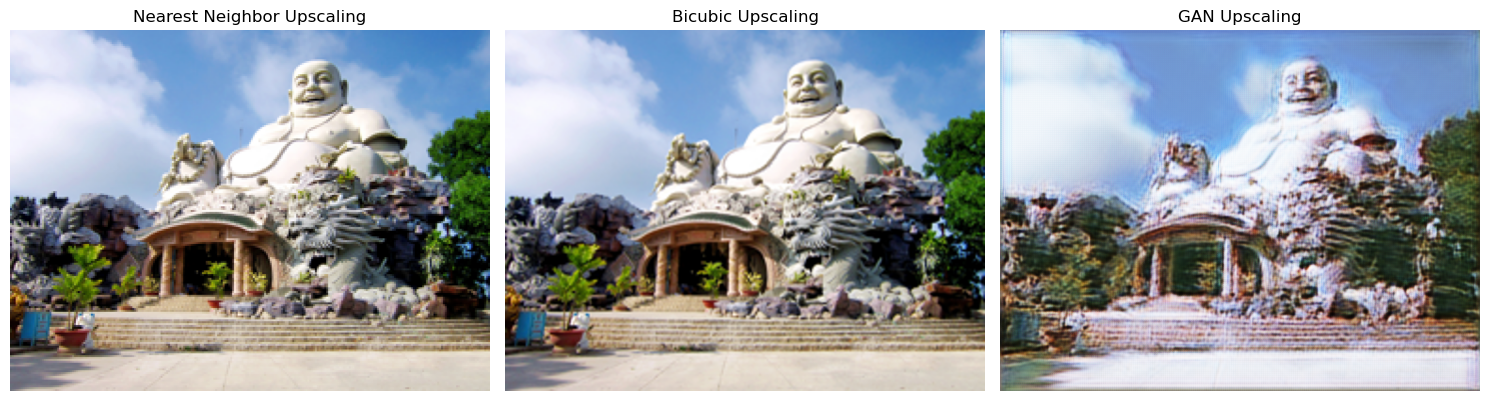

In [31]:
# Load the trained generator
generator.load_state_dict(torch.load(f"{output_dir}/generator_final.pth"))
generator.eval()

# Test on a custom image
test_image_path = "data/test/resized_0818.png"
test_upscale(test_image_path, generator, scale_factor)